# Predicting Why Employees Leave

# Definition

## Abstract

Measuring employee satisfaction is a tough and highly interdependent task. There are a lot of different dimensions in play and turning them into quantifiably format (less to say machine-readable information) can pose a challenge. Information from employee reviews, demographics, balanced scorecards and key performance indicators can offer a first gateway to understanding an employee’s desire to leave the company.

Summary of findings including:

* Intro sentence
* Add algorithms and preview of findings as well as novelty in approach
    * (i.e. combination of unsupervised and supervised algorithms)
* Critical thoughts about the research

## Introduction
According to the [Bureau of Labor Statistics](http://www.bls.gov/news.release/tenure.nr0.htm) the median number of years that wage and salary workers had been with their current employer was 4.2 years in January 2016. While this number varies from industry to industry the story of an employee who sticks with one company for the entirety of a working life seems to be rather antiquated. This observation is combined with the fact, that “employee turnover has been identified as a key issue for organizations because of its adverse impact on work place productivity and long term growth strategies”.[1] One of the key issues with a high employee turnover rate, combined with but reaching beyond cultural and sociological effects, is the cost associated with it. Research shows that the replacement cost for an hourly worker can be as high as 50 % of her annual salary. That number increases with the skillset of the worker up to 200% for senior-level workers and surges up to 400% for executive level positions.[2] It becomes obvious that the trend of shorter tenure in addition to high employee turnover rates can be a costly endeavour.
Therefore it becomes increasingly important to acquire the necessary tools for employers to understand where its workforce is standing. Additional insights from employer reports, scorecards as well as general statistical information can offer prediction values for companies when it comes to the longevity of jobs. 
This research aims to to predict the likelihood of an employee quitting based on available information and tryies to deliver supervised machine learning methods in order to gain actionable insights on how to prevent a high employee turnover.
The novel contribution of this paper is the usage of a two-layered approach using unsupervised and supervised machine learning algorithms to achieve a higher predictive outcome. 

## Literature Review
Employee turnover is a high impact topic that has been researched for a while in both, management as well as psychology studies. According to [23] the definition for employee turnover is "the gross movement of workers in and out of employment with respect to a given company". According to the [Bureau of Labor Statistic](https://www.bls.gov/bls/glossary.htm) there are two categories of turnover. Employee turnover is measured in terms of persons that quit their job, also known as voluntary turnover, and total separations. The subtraction of both numbers indicating the amount for unvoluntary turnover. 
In this research we will be focusing on voluntary turnover. [20] indicate that there are four categories of factors when it comes to employee turnover. Organization-wide factors, immediate work environment factors, job-related factors, and personal factors. 

[24] indicate in their model a multi-layered approach to turnover motivators including traditional features such as Job satisfaction, meeting ones expectation or job involvement as well as newer attitudes (i.e. stress, psychological uncertainty, challenge/hindrance stressors) or the organizational context (company size, group cohesion, demography, etc). Adding to the complexity of the field, research has shown, that turnover rates are also affected by moderating factors. [25] found that general job availability, movement capital and job satisfaction interacted with each other simultaneously to affect turnover. Also personal traits tend to have moderating effects.  The relationship between turnover intentions and turnover was moderated by various personality
traits such that the relationship was stronger for employees with low selfmonitoring, low risk aversion, and an internal locus of control [26].

According to [22] the relationship between job satisfaction and turnover is significant and consistent, but not particularly strong. The research suggests that a more complete understanding of the psychology of the withdrawal decision process requires investigation beyond the replication of the satisfaction–turnover relationship.

[21] recommend a thorough comparison of several models and data exploration. Explicitly stating the need to continue model testing rather than simply correlating variables with turnover.

[24] have found that most studies of voluntary turnover have one or two independent variables with voluntary turnover as the dependent variable. Machine learning algorithm are giving 

## Problem Statement
Machine learning differentiates between two classification problems. In some cases the data set contains unstructered data and machine learning is used to find clusters or classes. In other cases there are certain known classes already pre-defined and we are looking for relationships or rules to distinguish on class from another. The first category of classification is called unsupervised learning, the second category falls into supervised learning. This research deals with 2 classes in its dependent variable, whether an employee has left the company or is still employed. But since employee turnover research is manouvering in a highly inderdependent context, the underlying relationship between features and their impact on employee tenure this research wants to take customer clusters into account. 

The problem to be solved is detecting the key elements of employee tenure and predicting whether an employee might be quitting her job. The setup of this research can be seen as a classification problem. Based on a set of features our solution should be able to determine if an employee quits or stays with a company. The core path to solving this problem is a supervised learning approach which will test the relationship between our independent variables and our dependent variable (did an employee leave or stay). The tasks involved are the following:

1. Download and preprocess the kaggle dataset about employment
2. Use statistical methods such as descriptive analysis, regression and/or correlation to lay groundwork.
3. Train a clustering algorithm to group employees into different segments. 1
4. Train a classifier that determines whether an employee has left. 5. Compare our results against the benchmark model.

A desirable problem solution can be quantified by correct detection of potential job quitters and the amount of created intervention opportunities.
This problem affects companies from all sizes. Although it can be said that based on statistics there are certain industry traits that have a higher tenure, relative speaking the tendency to switch jobs has increased over time. The boundaries of this problem of course are the underlying mech- anisms of every individual company. These effects can not be generalized as in ‘how to prevent’ but more as in ‘how to predict’. Company culture, direct reports and individual needs might turn out to be far more complicated than a list of features. However, if we fix this problem the path to a more successful and sustainable company culture is given. It shall be stated that a mechanism such as this can only work as a supplement to human interaction and empathy skills.

## Solution Statement
First we’ll do an in-depth exploratory analysis in an attempt to explain the underlying relation- ships in the data set. Afterwards we are trying to approach this problem on two dimensions by combining unsupervised and supervised learning algorithms:

1. We’ll be trying to apply two clustering algorithms namely K-Means and Gaussian Mixture Model in an attempt to add more semantic to the employee set. Since we are operating in a sociological domain, the more we can derive from our feature set, the more human interaction and perception we can gather, the better. By clustering, we might be able to hand our supervised algorithm additional information for a better prediction down the road. In addition to this we might consider adding or engineering additional features from the existing feature set, depending on the questions we raise through this step.
2. Afterwards we’re going to use our features and additional cluster-information to predict whether an employee left or stayed. Given we established that we’re dealing with labeled data and considering the amount of data points we’re inclined to start with a Linear Support Vector Classifier or Logistic Regression and work our way through a KNeighbors Classifier implementation. Afterwards we’ll apply some even more sophisticated algorithms such as a Support Vector Classifier with polynomial or RBF kernel or ensemble methods like Random Forest Classifier or eXtreme Gradient Boosting.

In addition we’re trying to implement a model that will empower employers not only to de- tect, which of their own employees is about to leave the company but also determine which of the features contributes the most to a happy company culture. The success of our final solution however will be measured by its predicting accuracy on a held-out test set and the performance of our supervised learning approach.

## Benchmark
A lot of research and work has been performed to retain talent and decrease employee turnover rates. From corporate funded research and analytics services of companies such as [3] to management study classics such as [2] or more recent research [3] to name a few.
There are valid methods for predicting employee turnover rate and results that can be taken as benchmark models. In this research we’ll be using the machine learning approach of Punnose and Ajit as a benchmark. Their research performed predictive tasks on company information with an AUC (Area under the Curve) score of .86 on hold-out data as a best result using an XGBoost model.

### Evaluation Metrics
AUC (Area under the Curve) is a common evaluation metric for binary classification problems. Its value is between 0 to 1 and describes the accuracy of a binary classification based on its true positive values. As [described](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve), an area under the curve score is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.

To put this more into perspective, [kaggle](https://www.kaggle.com/wiki/AreaUnderCurve) describes a way of viewing AUC as a plot of the true positive rate vs. the false positive rate where the threshold value for classifying an item as 0 or is increased from 0 to 1. If the classifier is very good, the true positive rate will increase quickly and the area under the curve will be close to 1. If the classifier is no better than random guessing, the true positive rate will increase linearly with the false positive rate and the area under the curve will be around 0.5.

# Analysis

## Data Exploration

### Dataset & Variable Identification
In a dataset published on [kaggle](https://www.kaggle.com/ludobenistant/hr-analytics) information on current and former employees is offered plus key features of their exmployment status. Unfortunately there is no available codebook besides a brief information on the available inputs. 



In [38]:
# Read in data & import of packages & frameworks
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline

from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.layouts import column, row
from bokeh.plotting import reset_output
from bokeh.charts.attributes import cat
from collections import Counter
from IPython.display import display

plot_color = 'crimson'
cmap = sns.diverging_palette(222, 10, as_cmap=True)

hr_data = pd.read_csv('data/HR_comma_sep.csv', header=0)

In [39]:
# Rename column to fit better, get rid of typos and instill consistency
hr_data = hr_data.rename(
    columns = {'sales' : 'department', 
               'average_montly_hours' : 'average_monthly_hours',
               'Work_accident' : 'work_accident'})

First, let's have a look at how much data we're dealing with and how it's structured.

In [40]:
print "The data set has {} data points and {} variables.".format(*hr_data.shape)

The data set has 14999 data points and 10 variables.


In [41]:
print hr_data.columns.values

['satisfaction_level' 'last_evaluation' 'number_project'
 'average_monthly_hours' 'time_spend_company' 'work_accident' 'left'
 'promotion_last_5years' 'department' 'salary']


Given by its column names we have 10 variables that need to be taken into account. Since there is no additional information regarding the data set we are starting with some assumptions about the variables based on their description. Information that's comprised in this data set seems to include a measure of employee satisfaction level, evaluation scores, amount of projects and average monthly hours spend on the job, overall time spent at the company, whether the employee had a work accident or received a promotion within the last 5 years, a description of the department the employee works for and a salary indicator. In addition there is a variable called `left` that indicates, whether an employee is still actively working for this company or not.
In addition the dataset provides an indicator whether an employee has left. This indicator will be seen as the dependent variable that is being predicted.
This indicator will be seen as the dependent variable that is being predicted.



As a first summary, the predictors we will be using consist of:

* Employee satisfaction level 
* Last evaluation score
* Number of projects
* Average monthly hours
* Time spent at the company
* Whether they have had a work accident
* Whether they have had a promotion in the last 5 years 
* Department
* Salary

The target variable is `left`.

### Variable Description
As mentioned earlier, there is no codebook that can be linked to this data set. And since there is no additional information regarding the data set we are starting with some assumptions about the variables based on their description.

In [42]:
hr_description = hr_data.describe()
hr_description

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


A brief summary of the numeric values in the data set offers following insights about the variables:

* **satisfaction_level:** 1 most likely indicating a high satisfaction level [continuous value in the range of 0 and 1]
* **last_evaluation:** Most likely the rating of given employee [continuous numeric value between 0 and 1]
* **number_project:** The amount of projects an employee has. [discrete numeric value between 2 and 7]
* **average_monthly_hours:** The hours an employee works per month [continous numeric value between 96 and 310]
* **time_spend_company:** Given current working statistics we are most likely dealing with years. [discrete numeric value between 2 and 10]
* **work_accident:** Numeric expression of boolean value whether an employee had a work accident [discrete: 1 = true, 0 = false]
* **left:** Label if person left or not [discrete: 1 = true, 0 false]
* **promotion_last_5years:** Numeric expression of boolean value whether an employee was promoted within the last 5 years [discrete: 1 = true, 0 = false]

The dataset contains some non-numeric variables as well that need further exploration. `department` and `salary` have character values that seem to describe the data points further.

In [43]:
# Describe categorical data
print "hr_data['department']:", hr_data['department'].unique(), '\n'
print "hr_data['salary']:", hr_data['salary'].unique()

hr_data['department']: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD'] 

hr_data['salary']: ['low' 'medium' 'high']


This completes the variable descriptions and offers additional insights:

* **department:** Categorical variable describing the position of an employee. [discrete: sales, accounting, hr, technical, support, management, IT, product_mng, marketing, RanD]
* **salary:** Categorical variable indicating salary level of employee. [discrete: low, medium, high]

### Mean vs median
In order to decide whether to pick the mean or median values for comparison, we'll be computing the variance of each option.

In [58]:
# Mean or median
mean_by_dept = hr_data.groupby('department').mean()
median_by_dept = hr_data.groupby('department').median()

mm_comp = []
index = []
for row_mean, row_median in zip(mean_by_dept.var().iteritems(), median_by_dept.var().iteritems()):
    mm_comp.append([row_mean[1], row_median[1]])
    index.append(row_mean[0])

mm_comp = pd.DataFrame(mm_comp, columns=['mean', 'median'], index=index)
mm_comp

,mean,median
satisfaction_level,0.000157,0.000291
last_evaluation,0.000028,0.000143
number_project,0.005299,0.000000
average_monthly_hours,1.376778,4.011111
time_spend_company,0.077200,0.000000
work_accident,0.000276,0.000000
left,0.002177,0.000000
promotion_last_5years,0.001051,0.000000


There is clearly more information gain from the mean values in our data set. We'll be continuing using average values for our analysis where needed.

### Univariate Analysis
Next all variables are explored one-by-one. The method used depends on whether the variable is continuous or discrete. For continuous variables the spread and central tendency is important. For discrete variables frequency and histograms will be used to gain additional information. 

Based on the numeric information about mean, minimum and maximum values it can already be said that the numeric values seem to contain only little anomalies when it comes to tendency. The standard deviation values indicate a balanced dispersion. In order to visualize the findings. Density plots will further help investigate the distribution.

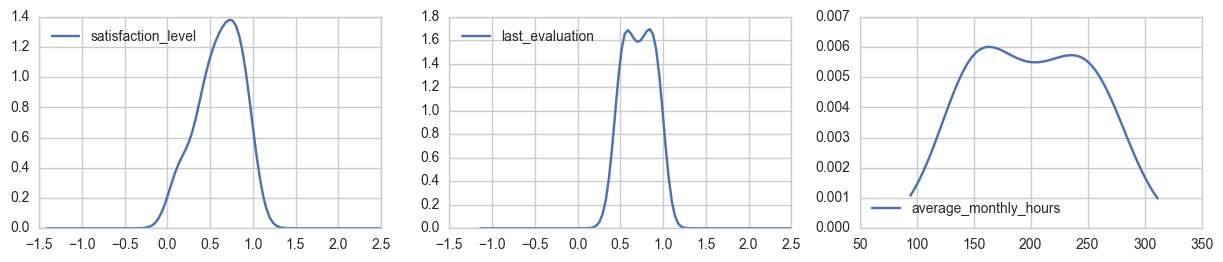

In [44]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 6))
plt.subplot(231)
ax1 = sns.kdeplot(hr_data['satisfaction_level'], bw=.5)
plt.subplot(232)
ax2 = sns.kdeplot(hr_data['last_evaluation'], bw=.5)
plt.subplot(233)
ax3 = sns.kdeplot(hr_data['average_monthly_hours'], bw=.5)

Given that the density curve describes the relative likelihood for a random variable to take on a given value, following observations can be made. With some smoothing, the `satisfaction_level` seems to be pretty normal in regards of distribution. Both `last_evaluation` as well as `average_monthly_hours` have two peaks. Yet there is no anomaly in the dibstribution.

The discrete variables can be explored with 

In [45]:
#plt.figure()
#plt.subplot(221)
#pd.DataFrame.from_dict(Counter(hr_data['department']), orient='index').plot()
cols = ['number_project', 
        'time_spend_company', 
        'department', 
        'salary', 
        'work_accident', 
        'left', 
        'promotion_last_5years']
col_dict = {}
for col in cols:
    col_dict[col] = pd.DataFrame.from_dict(Counter(hr_data[col]), orient='index')
    col_dict[col].columns = [col]

In [46]:
#discrete_vars = hr_data[['department', 'salary']]
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.layouts import column, row
from bokeh.plotting import reset_output
from bokeh.charts.attributes import cat
from collections import Counter
from IPython.display import display
row_coll = []
rows = []
block = True

for column in cols:
    block = True
    column_title_split = column.split('_')
    column_title = ""
    for column_title_piece in column_title_split:
        column_title += " " +column_title_piece.title()
    
    p = Bar(col_dict[column], 
            values=column, 
            title=column_title + ' Stats',
            color=plot_color,
            plot_width=300, 
            plot_height=200,
            ylabel="",
            legend=None,
            toolbar_location=None)
    rows.append(p)
    if len(rows) == 3:
        block = False
        row_coll.append(list(rows))
        reset_output()
        rows = []

if block:
    row_coll.append(list(rows))
    
#print row_coll
gridplot = gridplot(row_coll, toolbar_location=None)
output_notebook()
show(gridplot)

Loading BokehJS ...

In [71]:
#from math import round
print "{:.2f} % percent of all employees had a promotion within the last 5 years.".format(
    (len(hr_data[hr_data['promotion_last_5years'] == 1]) / 
    float(len(hr_data['promotion_last_5years']))) * 100)
print "{} out of 100 employees had a work related accident.".format(int(round((len(hr_data[hr_data['work_accident'] == 1]) / float(len(hr_data))) * 100)))

2.13 % percent of all employees had a promotion within the last 5 years.
14 out of 100 employees had a work related accident.


Looking at the frequency plots the `number_project` and `time_spend_company` distribution have a slight positive skew. It can be seen that the most employees tend to have 3 or 4 projects and tenure seems to level around 3 years. When it comes to `department`, the most employees are employed in sales with technical coming second and support being third on the list. The `salary` variable shows a clear skew towards low and medium wages what was to be expected. When it comes to work accidents, the data shows about 14 in 100 employees has had a work related accident. Even more severe is the skew when it comes to promotions. Only 2 out of 100 employees have had a promotion in the last 5 years. A slightly less severe but still significant skew is happening in the dependent variable `left`. This needs to be taken into account when splitting the data set for training, cross validation and training. 

### Missing Values
Another problem that might occur are missing values. 

In [81]:
# Check if there are any NaN values
for name, item in hr_data.isnull().sum().iteritems():
    if item > 0:
        print name

There are no missing values in the data set, which is fortunate.

## Data Context
To get a firmer grasp on some of the information hidden in the data set it's helpful to ask questions regarding the context of the data. Simple questions help putting a perspective on the information and offer a gateway to understanding the data. Questions that are being answered by this section are:

* How many people left their company?
* What's the average tenure?
* How do variables change by department?
    * Which department works the most hours?
    * Where do most work accidents appear?
    * What is the satisfaction level by department?

### How many people left their company
Let's see how the distribution of our indipendent variable looks like. It's important to note that we'll need a similar distribution of this variable for our training and testing sets.

In [95]:
people_left = len(hr_data[hr_data['left'] == 1])
print "{} Persons left their company ({:.3} %)".format(
    people_left, (people_left/float(len(hr_data))))

3571 Persons left their company (0.247 %)


### What's the average tenure over all departments

In [96]:
# Average tenure
print "Average tenure: {:.4}".format(hr_data['time_spend_company'].mean())

Average tenure: 3.306


It shows that people in our data set tend to leave the company earlier than the average depicted in the first paragraph. Which could indicate that the population we're looking at is either younger than the average work force or, more likely, that we're not representing state and federal employees which tend to have a way higher tenure (> 8 years).

### Exploration by department
In order to get a better grasp on the information that is contained in the data set, we'll be looking at the predictors through the eyes of each department.

In [107]:
row_coll = []
rows = []
counter = 1

for column in mean_by_dept.columns:
    column_title_split = column.split('_')
    column_title = ""
    for column_title_piece in column_title_split:
        column_title += " " +column_title_piece.title()
    
    p = Bar(mean_by_dept, 
            values=column, 
            title=column_title + ' by department',
            color=plot_color,
            plot_width=300, 
            plot_height=200,
            ylabel="",
            legend=None,
            toolbar_location=None)
    rows.append(p)
    if len(rows) == 3:
        row_coll.append(list(rows))
        reset_output()
        rows = []
    
row_coll.append(list(rows))
    
#print row_coll
gridplot = gridplot(row_coll, toolbar_location=None)
output_notebook()
show(gridplot)

Loading BokehJS ...

#### Insights by department
* The satisfaction level seems to be quite consistant over all departments. Only **accountants** & **HR** have a slight below average satisfaction level.
* Evaluation levels are on a consistant level over all departments.
* **HR** & **Marketing** seem to have slightly below average number of projects.
* All departments seem to clock in the same amount of time on a monthly basis. Guess there are only so much hours to the week. 
* **Management** is the clear frontrunner, when it comes to tenure. This makes sense, since a management position comes with greater responsibility & lock-in effects.
* **R&D**, **Management**, **Marketing** & **Support** seem to have the most hazardous work environment. With **Accounting** & **HR** being on the safety first side.
* **Management** & **R&D** have the highest average loyalty rate. **Accounting** & **HR** on the other hand are fluctuating quite a bit.
* **Management** have by far the highest promotion rate. In **Marketing** almost one out of two has had a promotion within the last 5 years, in the **R&D** department over 30 % has advanced on a professional level in the last 5 years. The **Support** and **Technical** departments are on the lowest spectrum.

## Bi-variate Analysis
It's good practice to get a grasp on how the variables are behaving in concert with each other. The relationship between two variables can tell us a lot about possible hypotheses that might be hidden in the data. In order to leverage this part of the analysis to its full extend One-Hot encoding will be performed for all discrete character filled variables, which is a step featured in the **Data Preprocessing**.

In [83]:
def preprocess_features(data):
    ''' 
    Preprocesses input data. 
    converts non-numeric binary variables into
    binary (0/1) variables. 
    Converts categorical variables into dummy variables. 
    '''
    output = pd.DataFrame(index = data.index)

    # Investigate each feature column for the data
    for col, col_data in data.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
        # Unify all column names by transforming to lower case
        output.columns = output.columns.str.lower()
    
    return output

hr_data = preprocess_features(hr_data)

print "Processed feature columns ({} total features):\n{}".format(
    len(hr_data.columns), list(hr_data.columns))

Processed feature columns (21 total features):
['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'work_accident', 'left', 'promotion_last_5years', 'department_it', 'department_randd', 'department_accounting', 'department_hr', 'department_management', 'department_marketing', 'department_product_mng', 'department_sales', 'department_support', 'department_technical', 'salary_high', 'salary_low', 'salary_medium']


## Regression & Correlation 

After encoding and preprocessing the data set we're curious in how the variables work with each other. This might be especially insightful when deciding which features to include or exclude. This is an important step to understanding what measures might be helpful when trying to prevent a high leaving rate.

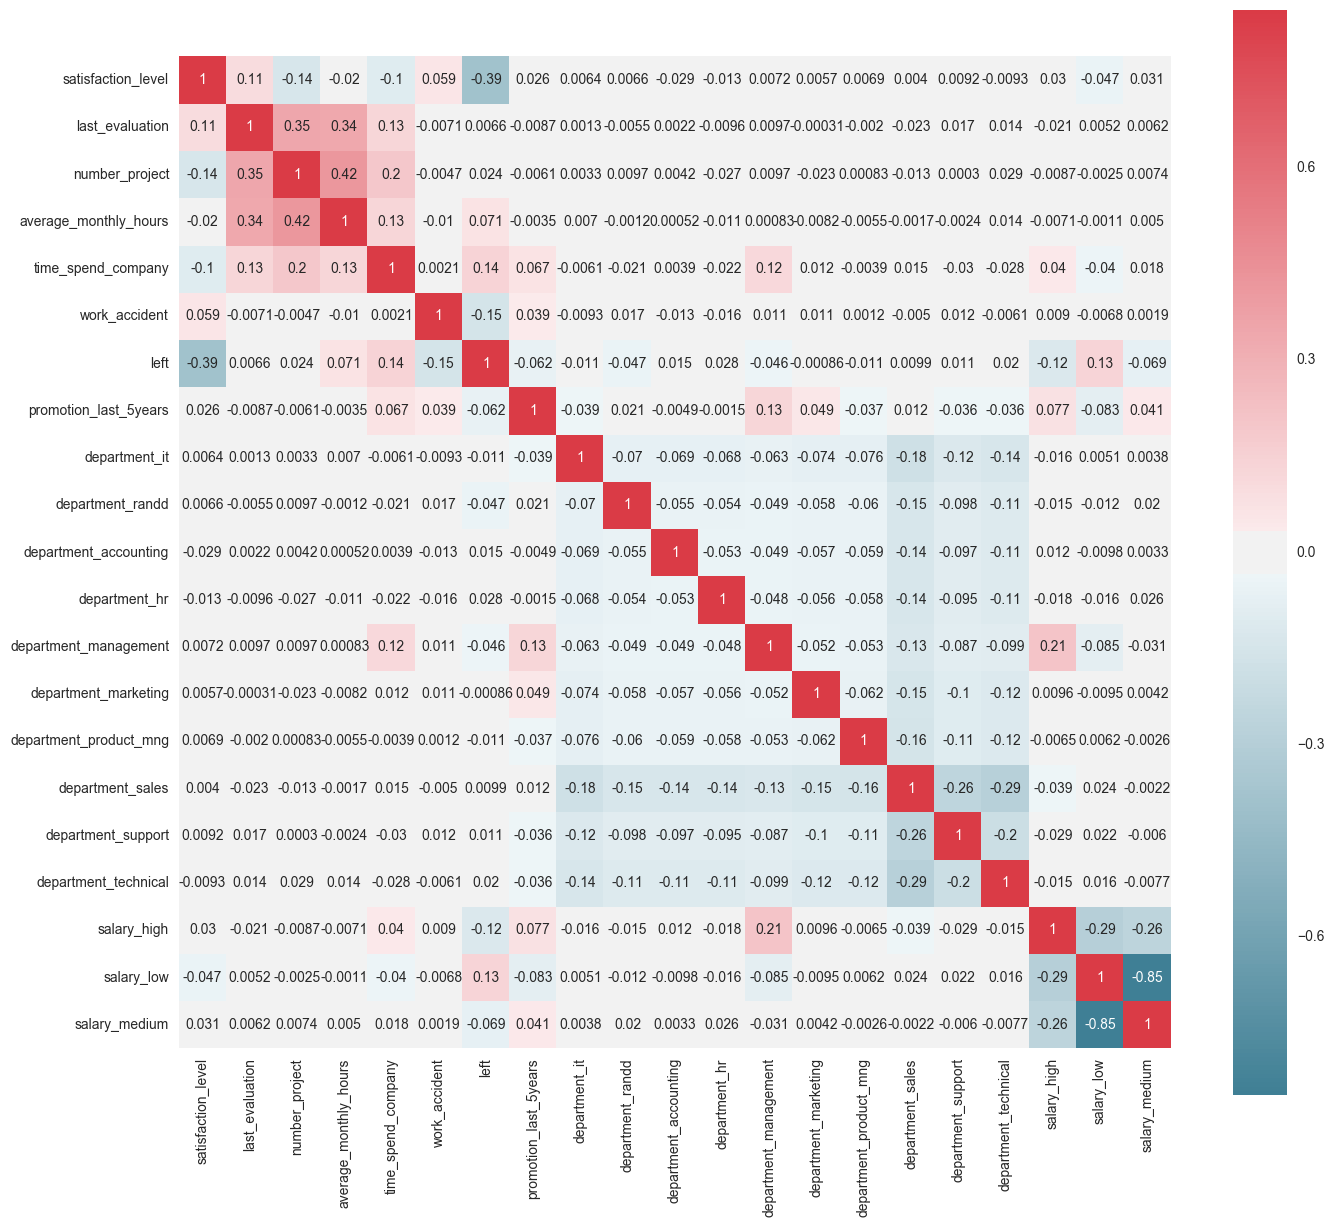

In [77]:
plt.figure(figsize=(16, 14))
cmap = sns.diverging_palette(222, 10, as_cmap=True)
_ = sns.heatmap(hr_data.corr(), annot=True, vmax=.8, square=True, cmap=cmap)

Just based on the heatmap there are already a couple of interesting observations one can make.

* A high satistfaction level seems to lead to a lower leaving rate.
* Employees with higher salary are less inclined to leave.
* On the other hand low salary employees seem to leave the company more often. 
* There's a positive correlation between the time a person spends at a company and the fact if they left.

But in order to get more granular we are interested in the highly correlated (strength > .1) and highly significant (p-Value > 0.05) connections.

In [84]:
def corr_table(data, features, sig_level=0.05, strength=0.0):
    import math
    import numpy as np
    from scipy.stats import pearsonr

    from operator import itemgetter
    p_val_dict = []
    check_dict = []
    for feature in features:
        feature_first = feature.split('_')[0]
        for label in features:
            # Since these correlations go in both directions, we only need to store on 
            # of the correlations and can discard the secon one
            # i.e. corr(age, Medu) has equal insights to corr(Medu, age)
            feature_comb = label+feature
            label_first = label.split('_')[0]
            
            if feature == label or feature_comb in check_dict or feature_first == label_first:
                #feature is already paired with label or equals label
                #or feature and label are from the same one-hot-encoding category
                continue
            else:
                check_dict.append(feature+label)
                pears = pearsonr(data[feature], data[label])
                p_val = pears[1]
                corr_strength = pears[0]
                cov_strength = np.cov(data[feature], data[label])[0][1]
                
                # Check if correlation is significant and has a high enough correlation
                if p_val < sig_level and math.fabs(corr_strength) > strength:
                    p_val_dict.append([feature, label, cov_strength, corr_strength, p_val])

    p_corr_title = 'Correlation > ' + str(strength)
    p_value_title = 'p-Value < ' + str(sig_level)
    p_val_dict = pd.DataFrame(p_val_dict, columns = ['Feature', 'Label', 'Covariance', p_corr_title, p_value_title])
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    p_val_dict['order'] = abs(p_val_dict[p_corr_title])
    p_val_dict.sort_values(by='order', inplace=True, ascending=False)
    p_val_dict.head()
    p_val_dict = p_val_dict.reset_index(drop=True)
    p_val_dict = p_val_dict.drop('order', axis=1)
    
    return p_val_dict



In [85]:
reg_features = hr_data_corr.columns[~hr_data_corr.columns.str.contains('left')]
label = reg_features

# How many significant correlations are in the data set?
correlations_all = corr_table(hr_data_corr, reg_features, strength=0.1)

In [86]:
correlations_all

,Feature,Label,Covariance,Correlation > 0.1,p-Value < 0.05
0,number_project,average_monthly_hours,25.6833,0.4172,0.0000
1,last_evaluation,number_project,0.0737,0.3493,0.0000
2,last_evaluation,average_monthly_hours,2.9044,0.3397,0.0000
3,department_management,salary_high,0.0115,0.2091,0.0000
4,number_project,time_spend_company,0.3542,0.1968,0.0000
5,satisfaction_level,number_project,-0.0438,-0.1430,0.0000
6,last_evaluation,time_spend_company,0.0329,0.1316,0.0000
7,promotion_last_5years,department_management,0.0037,0.1281,0.0000
8,average_monthly_hours,time_spend_company,9.3164,0.1278,0.0000
9,time_spend_company,department_management,0.0338,0.1154,0.0000


Based on our correlation analysis we can infer the following observations:
* Employees with a higher number of project tend to have a significant higher work load per month.
* A high evaluation level leads to an increase in the amount of projects (and therefore an increased monthly workload)
* People from the management department tend to have a higher salary
* An increase of number of project tends to a higher tenure rate.
* A low number of projects has a negative correlation with the satisfaction level.
* If the last evaluation was higher, the person was more likely to stay.
* As mentioned above, people from the management department tend to have a higher promotion rate.
* A high effort, measured by an average monthly hours, leads to a significant higher retention rate.
* People in management jobs have a higher tenure.
* A high last evaluation has a positive impact on the satisfaction level.
* A low satisfaction level has a negative correlation with the time an employee stays at a company.

### Outlier Detection
Another problem that might occur in a data set are outliers. Outliers can lead to wrong estimations and poor performance on some of the algorithms available. Simply put, an outlier is a data point that seems to be out of the normal when it comes to a variable or even multiple variables at once. Usually outliers can be univariate or multivariate which means that their abnormal values can either happen on one dimension or multiple variable dimensions. Going on the focus will be on univariate outliers.
The initial value to detect outliers used in this analysis is a 1.5 multiple of the Inner Quartile Range.

In [90]:
# Outlier detection
outliers = {}
outliers_all = []
sum = 0
# For each feature find the data points with extreme high or low values
for feature in hr_data[[0,1,2,3,4]].keys():
    
    # Calculates Q1 for the given feature
    Q1 = np.percentile(hr_data[feature], 25)
    
    # Calculates Q3 for the given feature
    Q3 = np.percentile(hr_data[feature], 75)
    
    # Calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    category_outliers = hr_data[~((hr_data[feature] >= Q1 - step) & (hr_data[feature] <= Q3 + step))]
    for outlier_no in category_outliers.index:
        if outlier_no in outliers:
            outliers[outlier_no] += 1
        else:
            outliers[outlier_no] = 1
            outliers_all.append(outlier_no)
    if len(category_outliers) > 0:
        print ""
        print "Data points considered outliers for the feature '{}' - (Min: {} - Max: {}):".format(feature, Q1, Q3)
        print "Outliers: {} ({:.2f} %)".format(len(category_outliers), 
                                              (len(category_outliers) / float(len(hr_data))) * 100 )
    else:
        print "No outliers for feature '{}'.".format(feature)
    #display(category_outliers)

No outliers for feature 'satisfaction_level'.
No outliers for feature 'last_evaluation'.
No outliers for feature 'number_project'.
No outliers for feature 'average_monthly_hours'.

Data points considered outliers for the feature 'time_spend_company' - (Min: 3.0 - Max: 4.0):
Outliers: 1282 (8.55 %)


The data looks pretty clean already, there are only outliers in the category `time_spend_company`. These outliers account for around 8.55 % of the overall data set. In order to determine if they should be removed from the data set we'll be looking more carefully. By increasing the tolerance for outliers, additional variance might be added but it gives us the opportunity to keep more data for our algorithms.

In [93]:
steps = [1.5, 2, 2.5, 3, 4, 5]

outlier_index = {}
for step_count in steps:
    outlier_data = hr_data['time_spend_company']
    Q1 = np.percentile(outlier_data, 25)
    Q3 = np.percentile(outlier_data, 75)
    step = step_count * (Q3 - Q1)
    category_outliers = hr_data[~((outlier_data >= Q1 - step) & 
                                    (outlier_data <= Q3 + step))]
    outlier_index[step_count] = category_outliers.index
    print "{}: \t {} \t ({:.2f} %)".format(step_count, 
                                     len(category_outliers), 
                                     (len(category_outliers) / float(len(outlier_data))) * 100)
    #print category_outliers.index

1.5: 	 1282 	 (8.55 %)
2: 	 564 	 (3.76 %)
2.5: 	 564 	 (3.76 %)
3: 	 376 	 (2.51 %)
4: 	 214 	 (1.43 %)
5: 	 214 	 (1.43 %)


Just widening the step range by `.5` reduces the outlier-rate by just shy of 5 %. To keep as much data as possible we'll remove outliers bigger or smaller than 2 times the Inner Quartile Range.

In [94]:
#norm_data = norm_data.drop(norm_data.index[outlier_index[2]]).reset_index(drop=True)
hr_data = hr_data.drop(hr_data.index[outlier_index[2]]).reset_index(drop=True)

## Algorithms and Techniques

### Supervised Algorithms

#### Support Vector Machine
Support Vector Machines are supervised learning algorithms implementing the principles of statistical learning theory. These will be used in a linear and non-linear implementation to account for a higher complexity of the data. SVMs tend to have a high accuracy while maintaining a fairly low variance (hence are more unlikely to overfit). This model works really well in complicated domains where there is a clear margin separation. SVMs construct a hyper-plane to distinguish the data points from each other. The intuition being that the larger the margin from the closest data points of each class the better the separation criteria.
Even if the data turns out to not be linearly separable, this model usually works quite well. However, if our data contains a lot of noise or gets too large, the model tends to perform poorly or very slow. So keeping in mind that we can expect the student data base to grow in the future this approach might become unfeasible at some point.

#### Logistic Regression
Logistic Regression is one of the basic linear models for classification. It's best used to predict binary or discrete dependent variables. LR is usually a quick and easy solution for machine-learning problems. It's implementation is fairly similar to SVMs with the great upside to work better on large data sets. Additional advantages being that there are a lot of ways to regularize the model and correlation of features doesn't matter as much. Another one of its main advantages is, that new data can easily be added and the model can be updated in an ongoing process. It's flexibility makes it a perfect choice for a running system, that should either be adjusted over time to model better or infused with more data. A downside of LR, is that it might have difficulties with binary features. In this dataset that contains a substantial set of categorical features this might become a problem.

#### Decision Tree Classifier
Another contender could be a Decision Tree model. Decision Trees are fairly easy to explain and interpret. They are also pretty robust against outliers and can be protected against overfitting through pruning. However, Decision Trees don't support online learning and have to be rebuild every time new information comes in. This might matter, if the data we are using is regularly updated and not only once a quarter. If we need an accurate turnover prediction model, that works year round on recent data and updated models, Decision Trees might have a downturn.

#### Random Forest
There are ensemble methods that incorporate trees such as Random Forest (RF). RF could prove itself with its ability to accept non-linear features. Other than LR it can handle categorical features very well. It's also well suited for high dimensional spaces (in case we wanted to add or engineer more features) and large numbers of training examples (for future application, once the data base grows). A major downside of RF-models though is it's lack of sensitivity towards correlated features. With correlated features, strong features might end up with low scores.

#### Extreme Gradient Boosting


Average CV performance for LinearSVC: 0.883877 (in 3.27746 seconds)
Training LogisticRegression ...
Average CV performance for LogisticRegression: 0.923883 (in 0.225934 seconds)
Training DecisionTreeClassifier ...
Average CV performance for DecisionTreeClassifier: 0.976879 (in 0.222815 seconds)
Training SVC ...
Average CV performance for SVC: 0.951334 (in 7.11911 seconds)
Training RandomForestClassifier ...
Average CV performance for RandomForestClassifier: 0.986232 (in 0.490239 seconds)

### Unsupervised Algorithms

## Selecting Samples
To get a better understanding of the employees and how their data will transform through the analysis, a few sample data points are being selected and explored in more detail. Three varying data points will be chosen and carried with us throughout the analysis.

In [38]:
#hr_data[hr_data['promotion_last_5years'] == 1].head(50)

In [39]:
indices = [1, 1100, 4509]
samples = pd.DataFrame(hr_data.loc[indices], columns = hr_data.keys(), index=indices)
print "Samples of hr dataset:"
samples

Samples of hr dataset:


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
1,0.80,0.86,5,262,6,0,1,0,sales,medium
1100,0.11,0.83,6,262,4,0,1,0,hr,low
4509,0.55,0.48,3,162,3,0,0,1,management,high


Based on these numbers, only the average monthly hours seem to be out of range for a descriptive plotting. A log normalization will be used to bring it into a format that's easier to display. Afterwards the average values for each category is being used to craft a first description of the sample.

In [40]:
#hr_plot = hr_data.copy()
#hr_plot['average_monthly_hours'] = np.log(hr_plot['average_monthly_hours'])
#samples = pd.DataFrame(hr_plot.loc[indices], columns = hr_plot.keys(), index=indices)

In [41]:
# only need to normalize numerical and not boolean attributes
hr_data_norm = hr_data[[0,1,2,3,4]]
hr_data_not_norm = hr_data[[5,6,7]]
hr_data_norm = (hr_data_norm - hr_data_norm.min()) / (hr_data_norm.max() - hr_data_norm.min())
for column in hr_data_not_norm.columns:
    hr_data_norm[column] = hr_data_not_norm[column]
samples = pd.DataFrame(hr_data_norm.loc[indices], columns = hr_data_norm.keys(), index=indices)
samples = samples[[0,1,2,3,4,5,6,7]]
samples

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years
1,0.780220,0.781250,0.6,0.775701,0.500,0,1,0
1100,0.021978,0.734375,0.8,0.775701,0.250,0,1,0
4509,0.505495,0.187500,0.2,0.308411,0.125,0,0,1


In [42]:
mean_plt = list()
labels = list()
for column in hr_data_norm[[0,1,2,3,4,5,6,7]].columns:
    mean_plt.append(hr_data_norm[column].mean())
    labels.append(column)
    #print "The category " + column + " has an average of: {:2,}".format(hr_plot[column].mean())
    
mean_plt = pd.DataFrame.from_records([mean_plt], columns=labels)
mean_plt.index = ['mean']

# mean_plt = hr_data_norm[[0,1,2,3,4,5,6,7]].describe()[1:2] # shortcut
samples = samples.append(mean_plt)

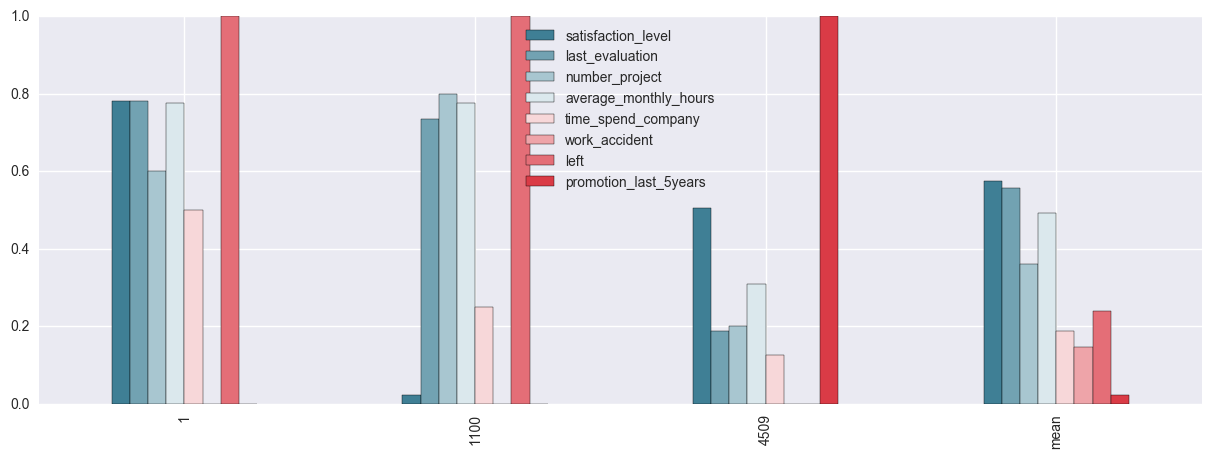

In [43]:
_ = samples.plot(kind='bar', figsize=(15,5), cmap=cmap)

### Employee Sample Description
The values of three samples can be seen in relation to the mean values of all shown categories. Just given by these numbers there are a couple of observations that can be made.

* **Employee 1: ** Has an above average satisfaction level and performed well on his last evaluation. The number of projects she has are above average as well and the monthly hours she works on average are high as well. In addition she spent above-average time at the company. With high satisfaction and evaluation levels as well as an above average amount of responsibility this employee seems to be a self-driven high performer. His above average time at the company make him a valuable partner for new employees.
* **Employee 1100: ** Has a way below average satisfaction level, yet performed well on her evaluation. She has an above average number of projects and spends more hours on them than the average employee. She has been with the company around the average of time. This employee seems to rely currently on outside motivation to perform his above average results. Yet the average time at the company could also indicate an individual that is affected by steep learning curves and needs to be more challenged with her work.
* **Employee 4509: ** Her satisfaction level is slightly below average. She hasn't received a good evaluation lately and her number of projects plus the time she spends at work are below average as well. She has spent less time at the company as the average as well, yet received a promotion within the last 5 years. Even though her satisfaction level is slightly below average the relation to her performance and responsibility level is out of proportion. 

### Feature Relevance
One interesting thought to consider is if one of the categories is relevant for understanding why an employee stays with a company. It might be possible that a category can be predicted by the other categories and therefore only contains limited information regarding our final goal. In simple terms, it might be possible that the level of responsibility can be predicted because of the constellation of all other categories. We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature. The coefficient of determination, R^2, is being used to determine the regression score. R^2 has a positive score range between 0 and 1, with 1 being a perfect fit. A negative R^2 implies the model fails to fit the data.

In [44]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

random_state = 42
data = hr_data_norm.copy().drop('left', axis = 1)
temp = {}

for label in data.columns:
    new_data = data.drop(label, axis = 1)
    new_data_labels = data[label]

    X_train, X_test, y_train, y_test = train_test_split(
        new_data, new_data_labels, test_size=0.25, random_state=random_state)

    regressor = DecisionTreeRegressor(random_state=random_state)
    regressor.fit(X_train, y_train)
    regressor.predict(X_test)
    
    score = regressor.score(X_test, y_test)
    temp[label] = score
    #print "Prediction score for " + label + " (R^2): " + str(score)
temp = pd.DataFrame.from_dict(temp, orient='index')
temp.columns = ['R^2 score']

In [45]:
temp.sort_values('R^2 score', ascending=False)

,R^2 score
number_project,0.196830
satisfaction_level,0.105357
average_monthly_hours,-0.016541
last_evaluation,-0.075494
time_spend_company,-0.091971
promotion_last_5years,-0.338921
work_accident,-0.600787


To get a better insight in the relevance of each category for understanding if an employee will stay at a company, we selected each category, dropped it from the data set and tried to predict its values based on the remaining categories. The Decision Tree Regressor failed to predict all categories but `number_of_project` and `satisfaction_level`. Which means all these categories are important. The R^2 scores for `number_of_project` and `satisfaction_level` (both below .2) show that the regression model had difficulties predicting the values as well. We can therefore infer that all numeric categories contain valuable information and should be used.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the employee features present in the data. If we found that the feature you attempted to predict above is relevant for identifying a specific employee, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific employee, the scatter matrix might show a correlation between that feature and another feature in the data.

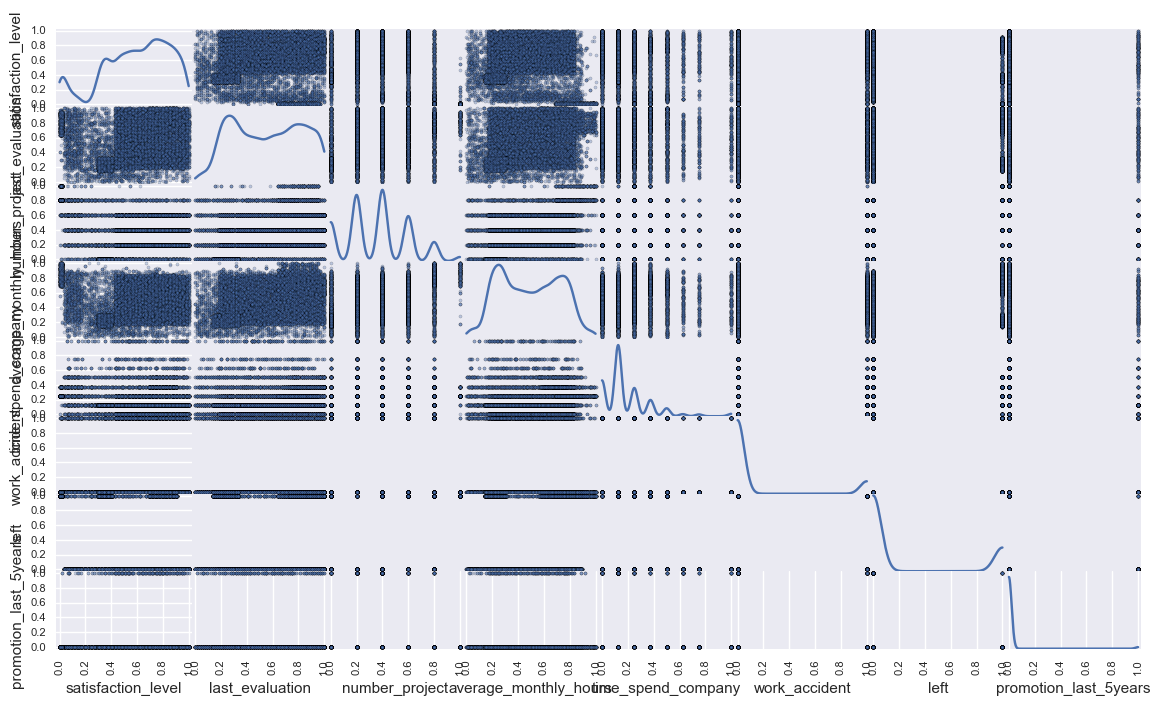

In [18]:
# Next we'll implement unsupervised learning to cluster employees into categories and see where this will lead us
pd.scatter_matrix(hr_data_norm, alpha = 0.3, figsize = (14,8), diagonal = 'kde', cmap=cmap);

Just by looking at the scatter matrix there are some observations that can be seen. There seem to be clusters available in the data that might be linked to correlations in between the features. Yet the description of these correlations will be determined later on.

In [68]:
norm_data = hr_data[[0,1,2,3,4]]
norm_data = (norm_data - norm_data.min()) / (norm_data.max() - norm_data.min())
norm_data.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company
0,0.318681,0.265625,0.0,0.285047,0.25
1,0.780220,0.781250,0.6,0.775701,1.00
2,0.021978,0.812500,1.0,0.822430,0.50
3,0.692308,0.796875,0.6,0.593458,0.75
4,0.307692,0.250000,0.0,0.294393,0.25


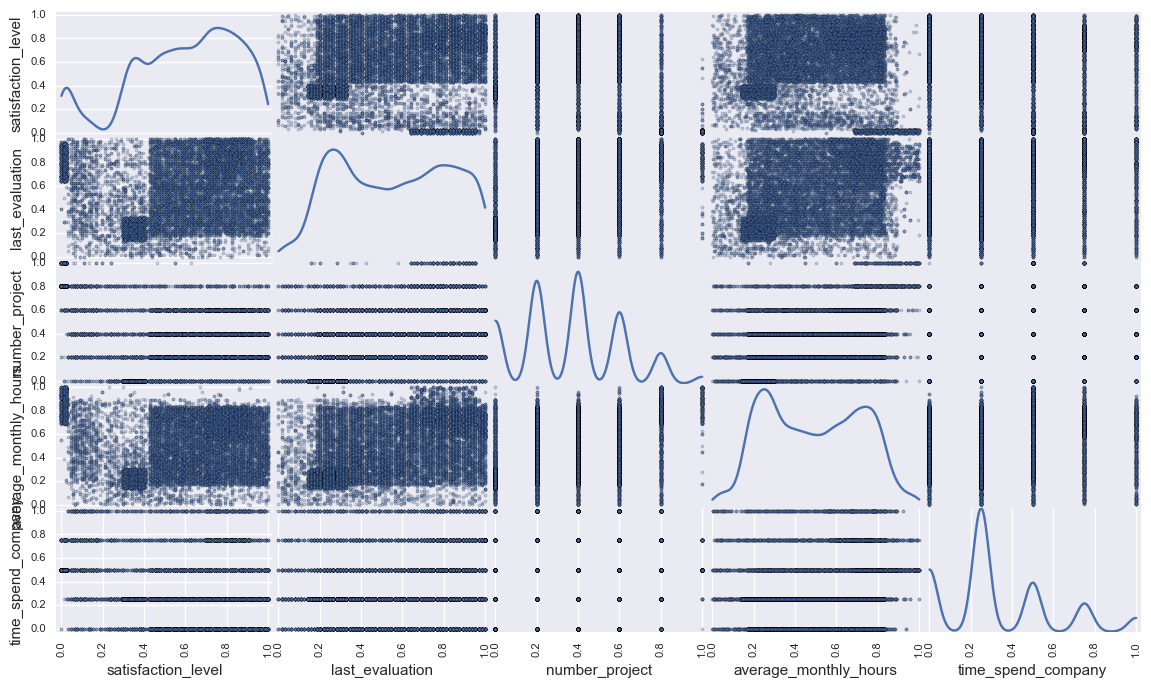

In [57]:
pd.scatter_matrix(norm_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde', cmap=cmap);

## Feature Transformation
- we can now apply PCA to the good_data to discover which dimensions about the data best maximize the variance of features involved
- In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension 
- how much variance within the data is explained by that dimension alone
- Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In [71]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.decomposition import pca

def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

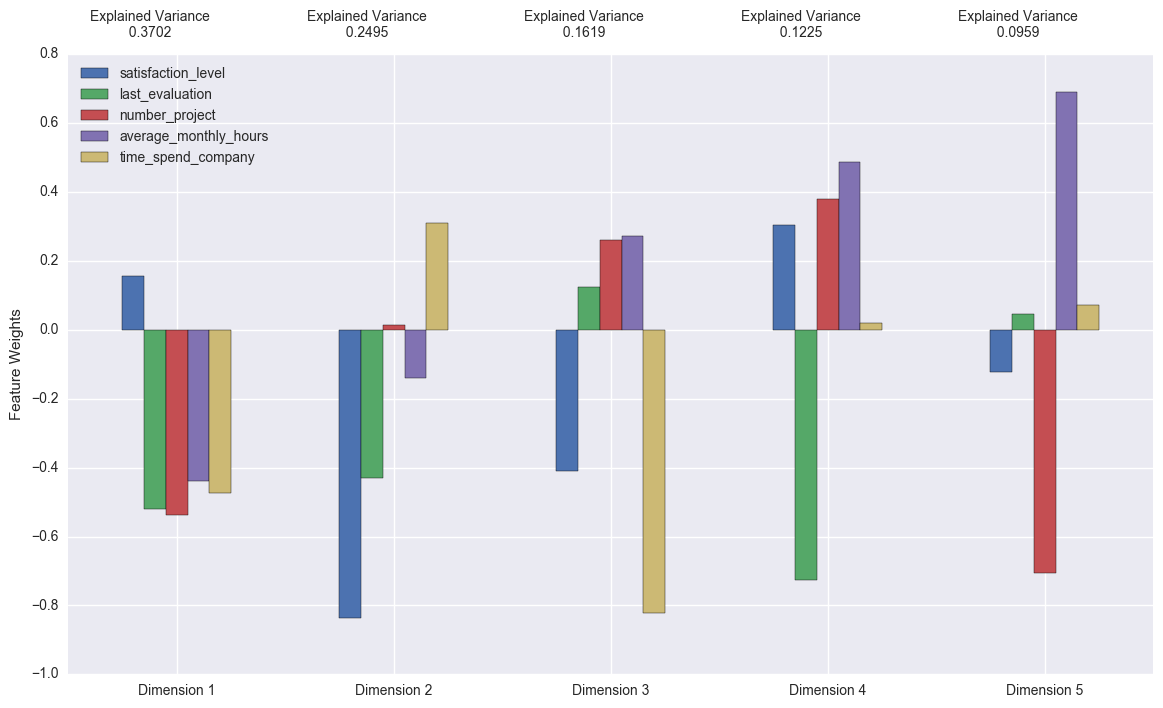

In [72]:
from sklearn.decomposition import PCA
#pca_data = norm_data.drop('left', axis=1)
pca_data = norm_data
pca = PCA(n_components=5)
pca = pca.fit(pca_data)

# TODO: Transform the sample log-data using the PCA fit above
#pca_samples = pca.transform(samples)

# Generate PCA results plot
pca_results = pca_results(pca_data, pca)

In [73]:
pd.DataFrame(data=[np.cumsum(pca.explained_variance_ratio_)], columns="Add " + 
             pca_results.index.values, index=['Combined Explained Variance'])

,Add Dimension 1,Add Dimension 2,Add Dimension 3,Add Dimension 4,Add Dimension 5
Combined Explained Variance,0.370203,0.619663,0.78159,0.904065,1.0


In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca = pca.fit(pca_data)
pca_samples = samples.drop('left', axis=1)
pca_samples = pca_samples[[0,1,2,3,4]]
reduced_data = pca.transform(pca_data)
pca_samples = pca.transform(pca_samples)
# TODO: Transform the sample log-data using the PCA fit above
#pca_samples = pca.transform(samples)

# Generate PCA results plot
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5'])

In [78]:
from sklearn import mixture
from sklearn.metrics import silhouette_score
redo = True
# TODO: Apply your clustering algorithm of choice to the reduced data 

score_list = []
score_columns = []
preds = {}
centers = {}
sample_preds = {}

for n in range(5,1,-1):
    print "Calculating clusters with {} dimensions.".format(n)
    clusterer = mixture.GMM(n_components=n)
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds[n] = clusterer.predict(reduced_data)
    # TODO: Find the cluster centers
    centers[n] = clusterer.means_
    # TODO: Predict the cluster for each transformed sample data point
    sample_preds[n] = clusterer.predict(pca_samples)
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds[n], metric='euclidean')
    score_list.append(score)
    score_columns.append(str(n) + " components")

score_list = pd.DataFrame(data=[score_list],columns=score_columns, index=['Silhouette Score'])
score_list

Calculating clusters with 5 dimensions.
Calculating clusters with 4 dimensions.
Calculating clusters with 3 dimensions.
Calculating clusters with 2 dimensions.


,5 components,4 components,3 components,2 components
Silhouette Score,0.214317,0.228157,0.215696,0.295411


2 components has the best silhouette score


In [79]:
def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    # Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
               s = 150, linewidth = 4, color = 'black', marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

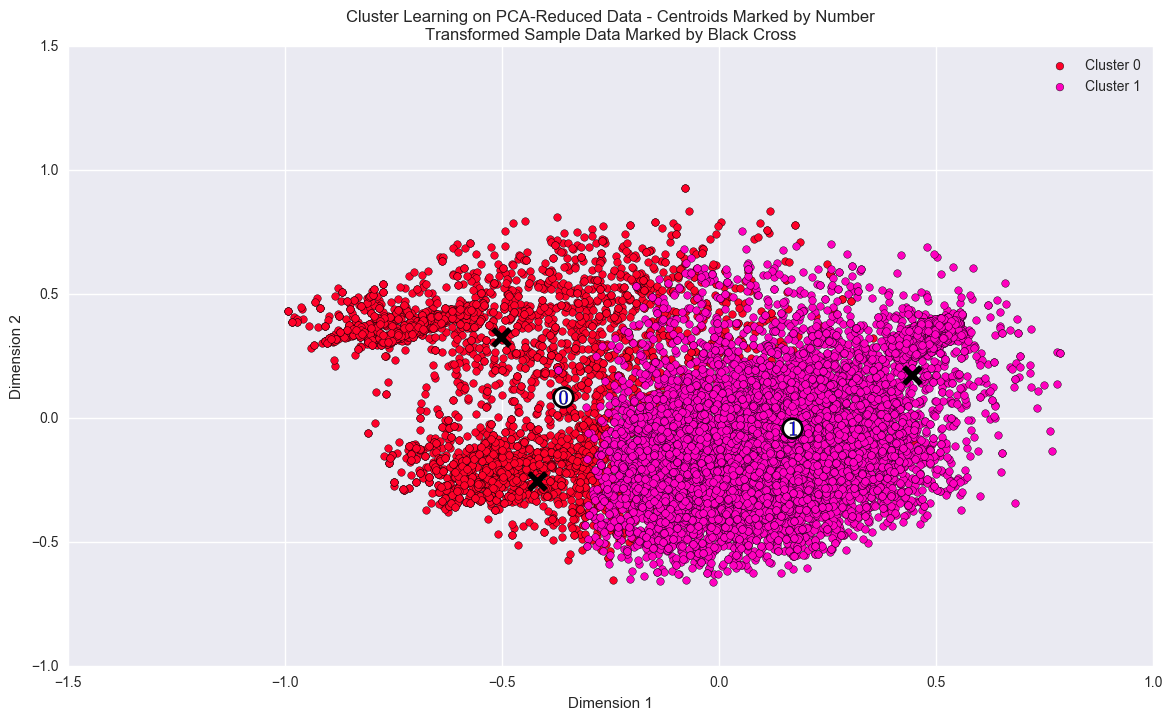

In [126]:
# with preds[n] and centers[n] where n is the number of Dimensions
cluster_results(reduced_data, preds[2], centers[2], pca_samples[:3])

In [127]:
predictions = pd.DataFrame(preds[2], columns = ['Cluster'])
norm_data['employee_cluster'] = predictions
hr_data['employee_cluster'] = predictions

In [128]:
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,employee_cluster
0,0.3800,0.5300,2,157,3,0,1,0,sales,low,1
1,0.8000,0.8600,5,262,6,0,1,0,sales,medium,0
2,0.1100,0.8800,7,272,4,0,1,0,sales,medium,0
3,0.7200,0.8700,5,223,5,0,1,0,sales,low,0
4,0.3700,0.5200,2,159,3,0,1,0,sales,low,1


In [106]:
print norm_data.columns
print hr_data.columns

Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_monthly_hours', u'time_spend_company', u'employee_cluster'],
      dtype='object')
Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_monthly_hours', u'time_spend_company', u'work_accident',
       u'left', u'promotion_last_5years', u'department', u'salary',
       u'employee_cluster'],
      dtype='object')


# Exploratory Visualization

In [57]:
mean_by_dept

NameError: name 'mean_by_dept' is not defined

In [109]:
pdf = pd.DataFrame.from_dict(Counter(hr_data['salary']), orient='index')
pdf.columns = ['Salary']

p = Bar(pdf,
        values='Salary',
        title='Salary',
        color=plot_color,
        plot_width=800, 
        plot_height=300,
        ylabel="Counts",
        legend=None,
        toolbar_location=None)

show(p)

In [110]:
pdf1 = pd.DataFrame.from_dict(Counter(hr_data['department']), orient='index')
pdf1['Department'] = pdf1.index
pdf1.columns =['Counts', 'Department']

pdf1.sort_values(by='Counts', inplace=True, ascending=False)
#pdf1 = pdf1.reset_index(drop=True)

p = Bar(pdf1,
        values='Counts',
        label=cat(columns='Department', sort=False),
        title='Counts',
        color=plot_color,
        plot_width=800, 
        plot_height=300,
        ylabel="Counts",
        legend=None,
        toolbar_location=None)
show(p)

pdf1

,Counts,Department
sales,3924,sales
technical,2688,technical
support,2191,support
IT,1189,IT
product_mng,866,product_mng
marketing,816,marketing
RandD,777,RandD
accounting,743,accounting
hr,733,hr
management,508,management


## Data preparation
Make data machine readable. One-hot-encoding for categorical cases.

In [111]:
def preprocess_features(data):
    ''' 
    Preprocesses input data. 
    converts non-numeric binary variables into
    binary (0/1) variables. 
    Converts categorical variables into dummy variables. 
    '''
    output = pd.DataFrame(index = data.index)

    # Investigate each feature column for the data
    for col, col_data in data.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

hr_data_corr = preprocess_features(hr_data)

print "Processed feature columns ({} total features):\n{}".format(
    len(hr_data_corr.columns), list(hr_data_corr.columns))

Processed feature columns (22 total features):
['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'work_accident', 'left', 'promotion_last_5years', 'department_IT', 'department_RandD', 'department_accounting', 'department_hr', 'department_management', 'department_marketing', 'department_product_mng', 'department_sales', 'department_support', 'department_technical', 'salary_high', 'salary_low', 'salary_medium', 'employee_cluster']


## Prediction
Let's move forward with the prediction process. After making all features machine readable we'll need to determine a model to use for our purposes. Because we want to find out, whether an employee left the company or is still employed, we'll approach this problem-set as a classification issue. 

Since we're dealing with a low-mid-range amount of labeled data (below 100K data points) we'll start the prediction task with a Linear Support Vector Machine. There are more sophisticated machine learning algorithm we can lean on but it's always a good idea to start at the bottom and work your way up. The second model we're looking into is a Decision Tree Classifier, because of its simplicity and computational efficiency. As a third contender we'll try implementing a more sophisticated Support Vector Machine that leverages additional dimensions through an rbf kernel and last but not least we'll be predicting through a Random Forest Classifier. Last but not least an eXtreme Gradient Boosting Algorithm is implemented.

Since sklearn makes it quite easy to add additional estimators as we go we'll go ahead and implement training and cross validation once and start looping over the process with our different models. eXtreme Gradient Boosting will be implemented seperately. 

### Setup
The prediction process will be as follows:
1. We'll split our correlation data set with all machine readable information into a training and a testing set. We'll leave out 40 % of the original datapints for testing purposes to validate our final model. In this step we'll make sure to use the stratify option while splitting in order to keep a similar distribution of label data in testing and training set.
2. The training features set will be split into independent (predictors) and dependent (label) variables. The predictors will be used to predict the label.
3. A random state will be set which will help with the reproducibility of the prediction process. (Note: Not all estimator implementations might have the option to seed a random state)
4. In order to avoid overfitting we'll perform k-fold cross-validation with k = 5. This means we'll split our training set in 5 separate buckets, use 4 of these buckets to train and the left out bucket for testing. CV performs this k-times. The average score will give a better indicator on how the model will perform on our testing set.

In [116]:
# Let's start the prediction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import cross_validation
from time import time

# Let's keep 40 % of the data for testing purposes
test_size = .2
random_state = 42

X_all = hr_data_corr.drop('left', 1)
y_all = hr_data_corr['left']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X_all, y_all, test_size = test_size, random_state = random_state, stratify=y_all)

clf_report = []
clf_feature_relevance = []

for clf in [LinearSVC(random_state = random_state),
            LogisticRegression(random_state = random_state),
            DecisionTreeClassifier(random_state = random_state),
            SVC(random_state = random_state),
            RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf.__class__.__name__
    print "Training", clf_name, "..."
    # Fit model on training data
    clf.fit(X_train, y_train)
    # Predict based on it
    # y_pred = clf.predict(X_train)
    
    # Perform cross validation
    start = time()
    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=5) 
    end = time()
    duration = end - start
    print "Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration)
    clf_report.append([clf_name, scores.mean(), duration])

    # Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance.append(clf.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance.append(clf.coef_[0].tolist())
# Store information in list for better visibility

clf_report = pd.DataFrame(clf_report, columns=['classifier', 'mean_score', 'time'])

Training LinearSVC ...
Average CV performance for LinearSVC: 0.883877 (in 3.27746 seconds)
Training LogisticRegression ...
Average CV performance for LogisticRegression: 0.923883 (in 0.225934 seconds)
Training DecisionTreeClassifier ...
Average CV performance for DecisionTreeClassifier: 0.976879 (in 0.222815 seconds)
Training SVC ...
Average CV performance for SVC: 0.951334 (in 7.11911 seconds)
Training RandomForestClassifier ...
Average CV performance for RandomForestClassifier: 0.986232 (in 0.490239 seconds)


In [117]:
import xgboost

In [118]:
print clf.get_params

<bound method RandomForestClassifier.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)>


In [119]:
pd.DataFrame(clf_feature_relevance, columns=X_train.columns, index=['LinearSVC', 
                                                                    'DecisionTreeClassifier', 
                                                                    'RandomForestClassifier'])

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,...,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium,employee_cluster
LinearSVC,-0.5216,0.6659,0.0389,0.0006,-0.3229,-0.4086,-0.1107,-0.0088,-0.1219,0.0322,...,0.0988,0.0374,0.0240,0.0646,0.0227,0.0914,-0.1655,0.3093,0.1880,-0.8486
DecisionTreeClassifier,0.0927,0.0798,0.0403,0.1658,0.0226,0.0013,0.0004,0.0005,0.0008,0.0015,...,0.0004,0.0004,0.0003,0.0005,0.0036,0.0028,0.0005,0.0024,0.0017,0.5816
RandomForestClassifier,0.2054,0.1025,0.0931,0.1248,0.0951,0.0060,0.0010,0.0014,0.0018,0.0013,...,0.0008,0.0013,0.0008,0.0028,0.0021,0.0031,0.0050,0.0054,0.0025,0.3424


In [120]:
clf_report.sort_values(by=['mean_score', 'time'], ascending=False)

,classifier,mean_score,time
4,RandomForestClassifier,0.9862,0.4902
2,DecisionTreeClassifier,0.9769,0.2228
3,SVC,0.9513,7.1191
1,LogisticRegression,0.9239,0.2259
0,LinearSVC,0.8839,3.2775


In [121]:
scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=5) 

In [122]:
scores.mean()

0.98623196521965273

In [123]:
predictor_list = []
for relevance in clf.feature_importances_:
    predictor_list.append(relevance)
new = pd.DataFrame(predictor_list, columns=['importance'], index=X_all.columns.values.tolist())
new.sort_values(by='importance', ascending=False, inplace=True)
new['features'] = new.index

p = Bar(new,
        values='importance',
        label=cat(columns='features', sort=False),
        title='Feature importance',
        color='crimson',
        plot_width=800, 
        plot_height=500,
        ylabel='importance',
        legend=None,
        toolbar_location=None)
show(p)

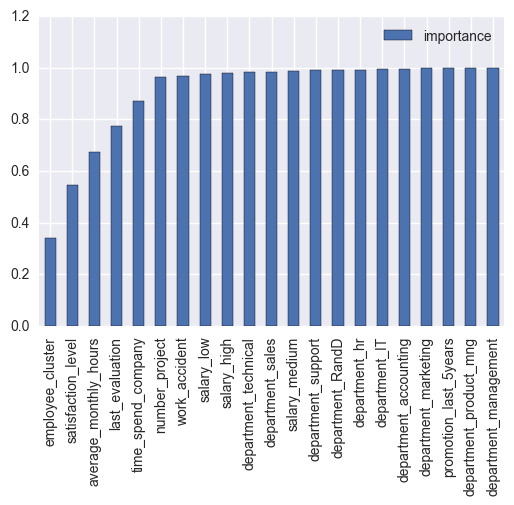

In [124]:
new.cumsum().plot(kind='bar')

#### New features
# underpaid (high working hours, low salary)



In [ ]:
# [20]
# Causes of employee turnover: A test of the Mobley, Griffeth, Hand, and Meglino model.
# Michaels, Charles E.; Spector, Paul E.
# Journal of Applied Psychology, Vol 67(1), Feb 1982, 53-59. http://dx.doi.org/10.1037/0021-9010.67.1.53
# http://psycnet.apa.org/journals/apl/67/1/53/

# [21]
# Employee Turnover: A Meta-Analysis and Review with Implications for Research
# John L. Cotton1 and Jeffrey M. Tuttle1

# [22]
# Intermediate linkages in the relationship between job satisfaction and employee turnover.
# Mobley, William H.
# Journal of Applied Psychology, Vol 62(2), Apr 1977, 237-240. http://dx.doi.org/10.1037/0021-9010.62.2.237
#http://psycnet.apa.org/journals/apl/62/2/237/

# [23]
# Mitchel, J. O. (1981). The effect of intentions, tenure, personal, and organizational variables on
# managerial turnover. Academy of Management Journal, 24, 742-750. 

# [24]
# “Turnover and retention research: A glance at the past, a closer review of the present, and a venture into the future”
# B. Holtom, T. Mitchell, T. Lee, and M. Eberly, 
# Academy of Management Annals, 2: 231-274, 2008

# [25]
# Trevor, C.O. (2001). Interactions among actual ease-of-movement determinants and
# job satisfaction in the prediction of voluntary turnover. Academy of Management
# Journal, 44, 621–638

# [26]
# Allen, D.G., Moffit, K.R., & Weeks. K.P. (2005). Turnover intentions and voluntary
# turnover: The moderating roles of self-monitoring, locus of control, proactive
# personality, and risk aversion. Journal of Applied Psychology, 90, 980–990.